In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors = ap.COLORS

# Plot accumulated precip 

In [5]:
cumsum=True

In [2]:
models = ["SCREAM", "ARP", "SHiELD", "GEOS", "UM", "SAM", "ICON"]

In [23]:
pr = {}
for i, m in enumerate(models):
    print(i, m, end="\t")
    if m=="ICON" or m=="SAM":
        # model output is already accumulated
        pr[m] = xr.open_dataset(ap.GT+"GT_{}r1deg_pracc_20200120-20200228.nc".format(m)).pracc.mean(axis=(1,2))
    else:
        # convert precip rate to accumulated
        temp = xr.open_dataset(ap.GT+"GT_{}r1deg_pr_20200120-20200228.nc".format(m)).pr
        if m!="ARP":
            temp = temp*900
        if m=="SCREAM":
            temp = temp*1000
        temp = temp.cumsum(axis=(0), skipna=True)
        pr[m] = temp.mean(axis=(1,2))
    print(pr[m].shape)

0 SCREAM	(3840,)
1 ARP	(3936,)
2 SHiELD	(3840,)
3 GEOS	(3936,)
4 UM	(3840,)
5 SAM	(3935,)
6 ICON	(3897,)


In [34]:
3840/4

960.0

In [29]:
np.linspace(0,3840/96,3840)

array([0.00000000e+00, 1.04193800e-02, 2.08387601e-02, ...,
       3.99791612e+01, 3.99895806e+01, 4.00000000e+01])

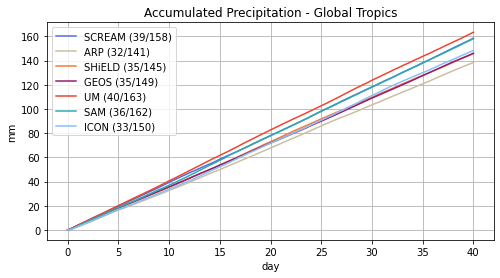

In [35]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for i, m in enumerate(models):
    ax.plot(np.linspace(0,3840/96,3840), pr[m][:3840], color=colors[m], label=m+" ({}/{})".format(str(int(pr[m][960].values)), str(int(pr[m][-1].values))))
ax.legend()
ax.grid(True)
ax.set_title("Accumulated Precipitation - Global Tropics")
ax.set_ylabel("mm")
ax.set_xlabel("day")
plt.savefig("../plots/GT/pracc_30days.png")
plt.show()